# 1. Define Modeler Class for Data Cleaning

In [1]:
import random
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb
import script.datacamp_common_function as dcf

class Modeler():

    def __init__(
        self,
        mode='train',
        factors_datas_names=[
            'factors_data',
            'fundamentals_data',
            'macros_data',
            'money_flows_data',
            'securities_margins_data',
            'industries_data',
            'indexes_data'
            ],
        other_datas_names=[
            'bank_stocks_info',
            'returns_data',
            'FCF_discounted_model_params_data'
            ],
        random_state=20241020
        ):
        self.mode = mode
        self.random_state = random_state
        # Define all data other than factors datas as class attributes
        for other_data_name in other_datas_names:
            other_data = pickle.load(open(f'data/exported_data/{other_data_name}_{mode}.pkl', mode='rb+'))
            if other_data_name == 'bank_stocks_info':
                self.industry_stocks_info = other_data
            elif other_data_name == 'returns_data':
                self.returns_data = other_data
            elif other_data_name == 'FCF_discounted_model_params_data':
                self.FCF_discounted_model_params_data = other_data

        self.index = self.FCF_discounted_model_params_data['r_wacc'].index
        self.columns = self.FCF_discounted_model_params_data['r_wacc'].columns

        # Merge multiple factor data tables
        factors_datas = {}
        # Import data
        for factors_data_category in factors_datas_names:
            factors_data = pickle.load(open(f'data/exported_data/{factors_data_category}_{mode}.pkl', mode='rb+'))
            factors_datas[factors_data_category] = factors_data
        
        self.factors_datas = factors_datas
        pickle.dump(obj=factors_datas, file=open(file=f'data/modeled_data/factors_datas_{self.mode}.pkl', mode='wb+'), protocol=4)

    # Check whether each factor is an empty table
    def check_factor_data_nan(self):
        factor_data_nan_dict = {}
        for factors_data_category, factors_data in tqdm(self.factors_datas.items(), desc='handling factors datas missing values progress'):
            factor_data_nan_dict[factors_data_category] = []
            for factor_data_code, factor_data in factors_data.items():
                if not factor_data.any().any():
                    factor_data_nan_dict[factors_data_category].append(factor_data_code)

        return factor_data_nan_dict
        

    # Define standardized factor risk classification data table
    def standardize_factors_risks_data(self):
        # Import the manually divided factor risk classification data table factors risks data, which has three columns, including the Chinese name of the factor, the factor code and the risk that the factor belongs to
        factors_risks_data = pd.read_csv('data/dict/factors_risks_data.csv')

        # Check the factors risks data for missing factor codes
        factors_codes_missing = []
        for _, factors_data in self.factors_datas.items():
            for factor_data_code in factors_data.keys():
                if factor_data_code not in factors_risks_data['factor_code'].values:
                    factors_codes_missing.append(factor_data_code)

        # Check the factors risks data for duplicate factor codes

        # Define factor codes list
        factors_codes = []
        for factors_data in self.factors_datas.values():
            factors_codes.append(list(factors_data.keys))

        # Define function to find duplicates in a given list
        def find_duplicates(lst):
            duplicates = []
            unique_elements = set()

            for item in lst:
                if item in unique_elements:
                    duplicates.append(item)
                else:
                    unique_elements.add(item)

            return duplicates
        
        # Find duplicates in the factor codes list
        factors_codes_duplicated = find_duplicates(factors_codes)
        
        # Check the factors risks data for redundant factor codes
        factors_codes_excessive = []
        for factor_code in factors_risks_data['factor_code'].values:
            if factor_code not in factors_codes:
                factors_codes_excessive.append(factor_code)

        # Unify the risk column in factors_risks_data to 3 dummy variables which display whether the factor belongs to the particular risk
        factors_risks_data = factors_risks_data.set_index('factor_code')
        factors_risks_data_standardized = pd.DataFrame(0, columns=['default_risk', 'liquidity_risk', 'market_risk'], index=factors_risks_data.index)
        for factor_code in factors_risks_data.index.tolist():
            if 'Default Risk' in factors_risks_data.loc[factor_code, 'risk']:
                factors_risks_data_standardized.loc[factor_code, 'default_risk'] = 1
            if 'Liquidity Risk' in factors_risks_data.loc[factor_code, 'risk']:
                factors_risks_data_standardized.loc[factor_code, 'liquidity_risk'] = 1
            if 'Market Risk' in factors_risks_data.loc[factor_code, 'risk']: 
                factors_risks_data_standardized.loc[factor_code, 'market_risk'] = 1

        self.factors_risks_data_standardized = factors_risks_data_standardized
        
        return factors_codes_missing, factors_codes_excessive, factors_codes_duplicated, factors_risks_data_standardized
    
    def _fill_nan_col(self, factor_data_without_type1_missing, factor_data):
        # Find the column names (factor codes) with all data missing (type2_missing) in factor_data_without_type1_missing
        missing_stocks_codes = factor_data_without_type1_missing.columns[factor_data_without_type1_missing.isnull().all()]
        # Calculate ranks for each rows of the columns within each rows of factor_data as a data table with index as column names
        missing_stocks_codes_quantiles = factor_data.rank(pct=True, axis=1)[missing_stocks_codes]
        # Calculate the mean rank of ranks for each rows of the columns as a series with index as column names
        missing_stocks_codes_quantiles_mean = missing_stocks_codes_quantiles.mean()
        # Covert the mean rank series to the corresponding mean quantile series within factor_data_without_type1_missing with index as column names
        fill_values = factor_data_without_type1_missing.quantile(missing_stocks_codes_quantiles_mean, axis=1)

        # Compatible fill_values and factor_data_without_type1_missing
        fill_values = fill_values.T
        fill_values.columns = missing_stocks_codes

        # Fill the columns' type2 missing values with the mean quantile series
        factor_data_without_type1_missing.update(fill_values) # Do not assign df to df, the former should take .values and become np.array, but it will still warn, so update is used
        return factor_data_without_type1_missing

    # Handle missing values
    def _handle_missing_values(self, factor_data):
        '''
        Some factor values in factor_data are missing. These missing values are either due to stocks not having factor values before listing or after delisting, or because factor values were not disclosed or recorded during the trading period. When handling missing values, the first type of missing values should be ignored, while the second type should be filled.
        There are generally three methods for filling missing values: SimpleImputation, KNNImputation, and IterativeImputation.
        For this panel data, SimpleImputation (such as mean or median filling) may not be suitable because it does not consider the time series characteristics and the correlation between stocks. Simply filling missing values with a constant may introduce bias, especially when the proportion of missing values is high.
        KNNImputation can consider the correlation between stocks, but it does not take into account the time series characteristics either. In addition, KNNImputation may be relatively slow when dealing with large-scale panel data because it requires calculating the distance matrix between all stocks. Therefore, IterativeImputer should be chosen. Its advantages and disadvantages include considering the time series characteristics and the correlation between stocks.
        However, using IterativeImputer to fill all missing values and then removing the first type of missing values may not be the best approach. This is because IterativeImputer considers all features, including those that should not exist and are to be filled (the first type of missing values), when estimating missing values. This may affect the quality of the estimates.
        Therefore, the following approach is a better choice. First, identify the sample dates (index) that do not contain the first type of missing values (all stocks are listed) and use only these samples to train the IterativeImputer. Then, use the trained IterativeImputer to estimate the second type of missing values in all samples. It is worth noting that some columns of these samples only contain missing values (the second type of missing values), and such samples cannot be used for training. We first obtain the average rank of each row in the entire data factor_data, then take the quantile corresponding to this rank in factor_data_without_type1_missing to fill the missing value column.
        '''
        # Define a mask to indicate whether each stock is listed at each time point
        mask = pd.DataFrame(index=self.index, columns=self.columns)
        # Get the median for each row (axis=1) of the factor data table to form a median vector for each cross-section
        medians = factor_data.median(axis=1)
        # For each stock code
        for stock_code in mask.columns:
            # For the stock with code stock_code, find its corresponding listing date start_date and delisting date end_date from the industry stocks information
            start_date = self.industry_stocks_info.loc[stock_code, 'start_date']
            end_date = self.industry_stocks_info.loc[stock_code, 'end_date']
            # Indicate whether the stock with code stock_code is listed at each time point
            mask[stock_code] = (mask.index >= start_date) & (mask.index <= end_date)
            
            # For the stock with code stock_code, if its factor values factor_data[stock_code] are all missing (np.nan) at all times
            if factor_data[stock_code].isnull().all():
                # Set the factor values for stock_code at all times to the median vector to prevent being ignored by the Imputer
                medians = pd.DataFrame(medians)
                medians.columns = [stock_code]
                factor_data.update(medians)
        
        # Based on the mask, get the date index that does not contain the first type of missing values (not listed)
        indexes_without_type1_missing = mask.all(axis=1)
        # Define the factor data sample corresponding to the date index without the first type of missing values
        factor_data_without_type1_missing = factor_data.loc[indexes_without_type1_missing]

        # For the columns in factor_data_without_type1_missing that are all missing values, obtain their average rank in the entire data factor_data,
        # and take the corresponding quantile in factor_data_without_type1_missing to fill the missing value column
        factor_data_without_type1_missing = self._fill_nan_col(factor_data_without_type1_missing, factor_data)
        
        # Define the IterativeImputer, which needs to be retrained after filling all missing values and then re-fill the original missing values until convergence,
        # with a maximum iteration count max_iter of 50 and a random seed random_state of self.random_state
        imputer = IterativeImputer(
            random_state=self.random_state,
            # Use IsolationXFBoost to fill missing values
            estimator=xgb.XGBRegressor(),
            max_iter=50,
            tol=1e-3
        )
        
        # Train the IterativeImputer using factor_data_without_type1_missing
        imputer.fit(factor_data_without_type1_missing)
        # Use the imputer to fill all missing values in factor_data, resulting in the filled factor data table factor_data_imputed
        factor_data_imputed = imputer.transform(factor_data)
        factor_data_imputed = pd.DataFrame(factor_data_imputed)
        factor_data_imputed.index = self.index
        factor_data_imputed.columns = self.columns

        # Re-label the first type of missing values in the filled factor data table factor_data_imputed back to np.nan,
        # that is, use the trained imputer to estimate all second type of missing values in the factor data table
        factor_data_imputed[~mask] = np.nan

        return factor_data_imputed
        
    # Fama-French-3分位数差值处理
    def _process_ff3_quantile_difference(self, factor_data):
        '''
        FF3 deals with forming cross-sectional stock return yield:
        Reasonability: If your research goal is to investigate the factor's cross-sectional predictive ability for stock return yield and assume that the cross-sectional distribution of stock return yield is related to the factor's cross-sectional distribution, then processing the cross-sectional stock return yield according to FF3 is appropriate.
        Advantages: This method can eliminate the extreme impact of stock return yield, making the distribution of cross-sectional stock return yield more stable, which is convenient for studying the predictive ability of the factor.
        Disadvantages: This method ignores the impact of enterprise value on stock return yield, and may not reflect the overall yield change in the market.
        '''
        panal_factor_data_quantiles = factor_data.quantile([0.3, 0.7], axis=1)
        panal_factor_data = panal_factor_data_quantiles.loc[0.7] - panal_factor_data_quantiles.loc[0.3]
        return panal_factor_data
    
    # Enterprise value weighting
    def _average_by_enterprise_value(self, factor_data):
        '''
        Form a enterprise value weighted sectoral factors data table:
        Reasonableness: If your research goal is to investigate the predictive power of factors on the overall market return, and you assume that the enterprise value of individual stocks reflects their importance in the market, then weighting the sectoral factors by enterprise value is appropriate.
        Advantages: This method takes into account the impact of enterprise value and reflects the overall change in market return, which is closer to the actual return of an investment portfolio.
        Disadvantages: This method may be dominated by large-cap stocks, and the impact of small-cap stocks may be obscured.
        For the research purpose of the bank sector in this paper, the weighted sectoral factors by enterprise value is chosen.
        '''
        weighted_factor_data = self.enterprise_value_weights * factor_data
        panal_factor_data = weighted_factor_data.sum(axis=1)

        panal_factor_data = pd.DataFrame(panal_factor_data)
        panal_factor_data.index = self.index
        #panal_factor_data.columns = [factor_data_code] # Do not reset column names to prevent missing values from appearing when comparing with other panal_factor_data calculations due to inconsistent column names
        return panal_factor_data

    # Missing value processing and Enterprise value weighting
    def clean_and_average_factors_datas(self):
        self.enterprise_value_weights = self.FCF_discounted_model_params_data['panal_enterprise_value_weights']
        industry_factors_df = pd.DataFrame()

        for factors_data_category, factors_data in self.factors_datas.items():
            for factor_data_code, factor_data in tqdm(factors_data.items(), desc='handling factors data progress'):
                if factors_data_category != 'macros_data': #factor_data_code == 'PEG': 
                    # Missing value processing
                    factor_data_imputed = self._handle_missing_values(factor_data)

                    # Enterprise value weighting
                    industry_factor_data = self._average_by_enterprise_value(factor_data_imputed)
                    # The r_wacc weighted by enterprise_value is obtained by summating the r_waac weighted by enterprise_value.
                    # Find r_E weighted by circulating_value and r_D weighted by Debts, respectively. Then r_E and r_D are weighted by the ratio of total circulating_value to the total enterprise_value and total Debts to the total enterprise_value of the section to get the r_wacc weighted by enterprise_value.
                    # These two processes are equivalent
                    industry_factors_df[factor_data_code] = industry_factor_data
        
        industry_factors_df.index = self.index
        self.industry_factors_df = industry_factors_df
        return industry_factors_df

    def clean_and_average_r_waac_data(self):
        self.enterprise_value_weights = self.FCF_discounted_model_params_data['panal_enterprise_value_weights']
        r_waac = self.FCF_discounted_model_params_data['r_wacc']
        industry_r_waac_df = pd.DataFrame()

        r_waac_imputed = self._handle_missing_values(r_waac)

        industry_r_waac = self._average_by_enterprise_value(r_waac_imputed)

        industry_r_waac_df['r_waac'] = industry_r_waac

        industry_r_waac_df.index = self.index

        self.industry_r_waac_df = industry_r_waac_df

        return industry_r_waac_df



# 2. Initialize the Modeler
The modeler imports data as DataFrames from pickles and align them into `Modeler.factors_datas`.

In [2]:
#from Modeler import Modeler

mode = input('Dataset is for train or test?')
mol = Modeler(mode)

## 2.1. Explore Original Data Structure
The `Modeler.factors_datas` includes 7 categories of financial factors (factors) about all listed banks in China, as the names shown:
* `'factors_data'`: Factors of banks' performance in stocks market in technical analyisis perspective.
* `'fundamentals_data'`: Factors from financial statement of banks.
* `'macros_data'`: Factors of macroeconomic enviroment.
* `'securities_margins_data'`: Factors of banks' margin trading.
* `'industries_data'`: Factors of bank's industry type: The bank is is a national or regional?
* `'indexes_data'`: Factor of total number of enterprises appearing in various composite indices.


In [3]:
mol.factors_datas.keys()

dict_keys(['factors_data', 'fundamentals_data', 'macros_data', 'money_flows_data', 'securities_margins_data', 'industries_data', 'indexes_data'])

Each category dict include many factors data table, take the category `'factors_data'` for example:

In [4]:
mol.factors_datas['factors_data'].keys()

dict_keys(['administration_expense_ttm', 'asset_impairment_loss_ttm', 'cash_flow_to_price_ratio', 'EBIT', 'EBITDA', 'financial_assets', 'interest_free_current_liability', 'market_cap', 'net_debt', 'net_finance_cash_flow_ttm', 'net_interest_expense', 'net_invest_cash_flow_ttm', 'net_operate_cash_flow_ttm', 'net_profit_ttm', 'non_operating_net_profit_ttm', 'non_recurring_gain_loss', 'np_parent_company_owners_ttm', 'OperateNetIncome', 'operating_assets', 'operating_profit_ttm', 'operating_revenue_ttm', 'retained_earnings', 'sales_to_price_ratio', 'total_operating_cost_ttm', 'total_operating_revenue_ttm', 'total_profit_ttm', 'value_change_profit_ttm', 'AR', 'ARBR', 'ATR14', 'ATR6', 'BR', 'DAVOL10', 'DAVOL20', 'DAVOL5', 'MAWVAD', 'money_flow_20', 'PSY', 'turnover_volatility', 'TVMA20', 'TVMA6', 'TVSTD20', 'TVSTD6', 'VDEA', 'VDIFF', 'VEMA10', 'VEMA12', 'VEMA26', 'VEMA5', 'VMACD', 'VOL10', 'VOL120', 'VOL20', 'VOL240', 'VOL5', 'VOL60', 'VOSC', 'VR', 'VROC12', 'VROC6', 'VSTD10', 'VSTD20', 'WVAD

Each indicator data table display the
* **not imputed** (missing values contained)
* **tail-shrinked** (outlies processed, see[1])
* **standardized**
* **industry-neutralized** and **circulating market capitalization-neutralized** (residualized, see[2]) \
indicator's values for all **(42)** Chinese listed banks (displayed as their codes) in **978** dates (from **2019-01-02** to **2022-12-30**), \

[1]: Treat the values ouside $[\operatorname{median} - 5\operatorname{IQR}, \operatorname{median} + 5\operatorname{IQR}]$ as outliers and replace them with the boundary value they hit. The oulier processing is conservative because the data is due to formal statistical process which preserve its reality. \
[2]: $\operatorname{factor_i} = \beta_0 + \beta_1 \operatorname{industry}_i + \beta_2 \operatorname{market \space capitalization}_i + \epsilon_i$ where $i$ denotes the ordinal number of the bank and $\operatorname{industry}_i := \mathbb{I}(\text{bank}_i \space \text{is in the industry})$. The $\epsilon_i$, as residualized $\operatorname{factor_i}$ is called neturalized $\operatorname{factor_i}$ which is used to orthogonalize $\operatorname{factor_i}$ from $\operatorname{industry}_i$ and $\operatorname{market \space capitalization}_i$.

---
Take a indicator `'administration_expense_ttm'` form category `'factors_data'` for example:

In [5]:
mol.factors_datas['factors_data']['administration_expense_ttm']

code,600928.XSHG,600016.XSHG,002807.XSHE,600926.XSHG,601658.XSHG,002142.XSHE,601229.XSHG,002966.XSHE,600000.XSHG,002936.XSHE,...,603323.XSHG,601328.XSHG,601398.XSHG,601528.XSHG,601838.XSHG,601988.XSHG,601825.XSHG,601997.XSHG,601128.XSHG,600015.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,-0.192939,-0.153628,-0.003386,NaN,0.184528,0.147090,NaN,-0.364477,-0.073653,...,-0.151028,0.473023,0.625446,NaN,-0.082815,0.625446,NaN,-0.055402,-0.113116,-1.167848
2019-01-03,NaN,-0.019341,-0.163877,0.007466,NaN,0.221772,0.179076,NaN,-0.214971,-0.072671,...,-0.160913,0.450172,0.450172,NaN,-0.083119,0.450172,NaN,-0.051856,-0.117675,-1.131176
2019-01-04,NaN,-0.019341,-0.163877,0.007466,NaN,0.221772,0.179076,NaN,-0.214971,-0.072671,...,-0.160913,0.450172,0.450172,NaN,-0.083119,0.450172,NaN,-0.051856,-0.117675,-1.131176
2019-01-07,NaN,-0.019341,-0.163877,0.007466,NaN,0.221772,0.179076,NaN,-0.214971,-0.072671,...,-0.160913,0.450172,0.450172,NaN,-0.083119,0.450172,NaN,-0.051856,-0.117675,-1.131176
2019-01-08,NaN,-0.019341,-0.163877,0.007466,NaN,0.221772,0.179076,NaN,-0.214971,-0.072671,...,-0.160913,0.450172,0.450172,NaN,-0.083119,0.450172,NaN,-0.051856,-0.117675,-1.131176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,-0.2165,0.183639,-0.250547,0.159265,0.183639,0.807242,0.327506,-0.11693,0.183639,-0.137717,...,-0.246006,0.183639,0.183639,-0.25452,-0.061778,0.183639,0.071807,-0.099515,-0.131597,-0.712826
2022-12-27,-0.2165,0.183639,-0.250547,0.159265,0.183639,0.807242,0.327506,-0.11693,0.183639,-0.137717,...,-0.246006,0.183639,0.183639,-0.25452,-0.061778,0.183639,0.071807,-0.099515,-0.131597,-0.712826
2022-12-28,-0.2165,0.183639,-0.250547,0.159265,0.183639,0.807242,0.327506,-0.11693,0.183639,-0.137717,...,-0.246006,0.183639,0.183639,-0.25452,-0.061778,0.183639,0.071807,-0.099515,-0.131597,-0.712826


More details about indicators see the following dictionary data table or [Data Dictionary from JoinQuant](https://www.joinquant.com/help/api/help#name:aboutData):

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

pd.read_csv('data/dict/factors_datas_dicts_english.csv')

,Factor Code,Factor Name,Details,Supplimental Details,Factor Category
0,size,Market capitalization,Capturing the difference in earnings between l...,NaN,factors_data
1,beta,Beta,Characterize the volatility sensitivity of sto...,NaN,factors_data
2,momentum,Conventional momentum,Describes the difference between relatively st...,NaN,factors_data
3,residual_volatility,Residual volatility,Explain the difference in yield caused by the ...,NaN,factors_data
4,non_linear_size,Nonlinear Market Cap,Describes differences in returns that cannot b...,NaN,factors_data
5,book_to_price_ratio,Book-to-market ratio,Describes the income difference caused by diff...,NaN,factors_data
6,liquidity,Liquidity,This paper explains the difference of yield ca...,NaN,factors_data
7,earnings_yield,Profitability,Describes the difference in earnings resulting...,NaN,factors_data
8,growth,Grow up,Describes the difference in earnings resulting...,NaN,factors_data
9,leverage,Leverage,Describes the difference in returns between hi...,NaN,factors_data


# 3 Data Cleaning
---
## 3.1 Check whether each factor is an empty table

if yes, delete it.

In [7]:
mol.check_factor_data_nan()

handling factors datas missing values progress: 100%|██████████| 7/7 [00:00<00:00, 33.39it/s]


{'factors_data': [],
 'fundamentals_data': [],
 'macros_data': [],
 'money_flows_data': [],
 'securities_margins_data': [],
 'industries_data': [],
 'indexes_data': []}

No factors data table are empty.

## 3.2 Define standardized factor risk classification data table
Import the manually divided factor risk classification data table factors risks data, which has three columns, including the Chinese name of the factor, the factor code and the risk that the factor belongs to

In [8]:
try:
    mol.factors_risks_data_standardized = pd.read_csv('data/dict/factors_risks_data_standardized.csv')
except:
    factors_codes_missing, factors_codes_excessive, factors_codes_duplicated, mol.factors_risks_data_standardized = mol.standardize_factors_risks_data()
    mol.factors_risks_data_standardized.to_csv('data/dict/factors_risks_data_standardized.csv', encoding='utf-8')

The risk classification, i.e. the risks contained in the factors are as follow:

In [9]:
mol.factors_risks_data_standardized

,factor_code,default_risk,liquidity_risk,market_risk
0,size,0,0,1
1,beta,0,0,1
2,momentum,0,0,1
3,residual_volatility,0,1,1
4,non_linear_size,0,0,1
5,book_to_price_ratio,1,0,1
6,liquidity,0,1,0
7,earnings_yield,1,0,0
8,growth,1,0,0
9,leverage,1,0,0


## 3.3 Missing values processing and Enterprise value weighting

* Missing values processing: 
> Some factor values in factor_data are missing. These missing values are either due to stocks not having factor values before listing or after delisting, or because factor values were not disclosed or recorded during the trading period. When handling missing values, the first type of missing values should be ignored, while the second type should be filled. \
    There are generally three methods for filling missing values: SimpleImputation, KNNImputation, and IterativeImputation[1]. \
    For this panel data, SimpleImputation (such as mean or median filling) may not be suitable because it does not consider the time series characteristics and the correlation between stocks. Simply filling missing values with a constant may introduce bias, especially when the proportion of missing values is high. \
    KNNImputation can consider the correlation between stocks, but it does not take into account the time series characteristics either. In addition, KNNImputation may be relatively slow when dealing with large-scale panel data because it requires calculating the distance matrix between all stocks. Therefore, IterativeImputer should be chosen. Its advantages and disadvantages include considering the time series characteristics and the correlation between stocks.
    However, using IterativeImputer to fill all missing values and then removing the first type of missing values may not be the best approach. This is because IterativeImputer considers all features, including those that should not exist and are to be filled (the first type of missing values), when estimating missing values. This may affect the quality of the estimates. \
    Therefore, the following approach is a better choice. First, identify the sample dates (index) that do not contain the first type of missing values (all stocks are listed) and use only these samples to train the IterativeImputer. Then, use the trained IterativeImputer to estimate the second type of missing values in all samples. It is worth noting that some columns of these samples only contain missing values (the second type of missing values), and such samples cannot be used for training. We first obtain the average rank of each row in the entire data factor_data, then take the quantile corresponding to this rank in factor_data_without_type1_missing to fill the missing value column. \
* Enterprise value weighting:
> Form a enterprise value weighted sectoral factors data table: \
Reasonableness: If your research goal is to investigate the predictive power of factors on the overall market return, and you assume that the enterprise value of individual stocks reflects their importance in the market, then weighting the sectoral factors by enterprise value is appropriate. \
Advantages: This method takes into account the impact of enterprise value and reflects the overall change in market return, which is closer to the actual return of an investment portfolio. \
Disadvantages: This method may be dominated by large-cap stocks, and the impact of small-cap stocks may be obscured.
For the research purpose of the bank sector in this paper, the weighted sectoral factors by enterprise value is chosen.

For example:

[1]: IterativeImputer iterates the following steps:
1. Be trained on the complete part of data
2. Impute all missing values
3. Be retrained on this imputed data
Repeat step 2 and 3 until convergence of imputation.

In [10]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')

mol.factors_datas['factors_data']['administration_expense_ttm']

code,600928.XSHG,600016.XSHG,002807.XSHE,600926.XSHG,601658.XSHG,002142.XSHE,601229.XSHG,002966.XSHE,600000.XSHG,002936.XSHE,...,603323.XSHG,601328.XSHG,601398.XSHG,601528.XSHG,601838.XSHG,601988.XSHG,601825.XSHG,601997.XSHG,601128.XSHG,600015.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,-0.192939,-0.153628,-0.003386,NaN,0.184528,0.147090,NaN,-0.364477,-0.073653,...,-0.151028,0.473023,0.625446,NaN,-0.082815,0.625446,NaN,-0.055402,-0.113116,-1.167848
2019-01-03,NaN,-0.019341,-0.163877,0.007466,NaN,0.221772,0.179076,NaN,-0.214971,-0.072671,...,-0.160913,0.450172,0.450172,NaN,-0.083119,0.450172,NaN,-0.051856,-0.117675,-1.131176
2019-01-04,NaN,-0.019341,-0.163877,0.007466,NaN,0.221772,0.179076,NaN,-0.214971,-0.072671,...,-0.160913,0.450172,0.450172,NaN,-0.083119,0.450172,NaN,-0.051856,-0.117675,-1.131176
2019-01-07,NaN,-0.019341,-0.163877,0.007466,NaN,0.221772,0.179076,NaN,-0.214971,-0.072671,...,-0.160913,0.450172,0.450172,NaN,-0.083119,0.450172,NaN,-0.051856,-0.117675,-1.131176
2019-01-08,NaN,-0.019341,-0.163877,0.007466,NaN,0.221772,0.179076,NaN,-0.214971,-0.072671,...,-0.160913,0.450172,0.450172,NaN,-0.083119,0.450172,NaN,-0.051856,-0.117675,-1.131176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,-0.2165,0.183639,-0.250547,0.159265,0.183639,0.807242,0.327506,-0.11693,0.183639,-0.137717,...,-0.246006,0.183639,0.183639,-0.25452,-0.061778,0.183639,0.071807,-0.099515,-0.131597,-0.712826
2022-12-27,-0.2165,0.183639,-0.250547,0.159265,0.183639,0.807242,0.327506,-0.11693,0.183639,-0.137717,...,-0.246006,0.183639,0.183639,-0.25452,-0.061778,0.183639,0.071807,-0.099515,-0.131597,-0.712826
2022-12-28,-0.2165,0.183639,-0.250547,0.159265,0.183639,0.807242,0.327506,-0.11693,0.183639,-0.137717,...,-0.246006,0.183639,0.183639,-0.25452,-0.061778,0.183639,0.071807,-0.099515,-0.131597,-0.712826


In [11]:
(mol.FCF_discounted_model_params_data['panal_enterprise_value_weights'] * mol.factors_datas['factors_data']['administration_expense_ttm']).agg('sum', axis=1)

date
2019-01-02    0.280478
2019-01-03    0.201603
2019-01-04    0.201571
2019-01-07    0.201541
2019-01-08    0.201483
                ...   
2022-12-26    0.126160
2022-12-27    0.126219
2022-12-28    0.126257
2022-12-29    0.126236
2022-12-30    0.126251
Length: 972, dtype: float64

Through Enterprise value weighting, we transform a sectoral row in a given date into a value, and sectoral rows in any dates (factors data table) into values in any dates (factor series).

---
For `factors_datas`, do the above:

In [14]:
try:
    mol.industry_factors_df = pd.read_csv('data/modeled_data/bank_factors_df_train.csv', index_col='date')
except:
    mol.industry_factors_datas = mol.clean_and_average_factors_datas()
    mol.industry_factors_df.to_csv('data/modeled_data/bank_factors_df_train.csv', encoding='utf-8')

For `r_waac_data`, do the same:

In [15]:
try:
    mol.industry_r_waac_df = pd.read_csv('data/modeled_data/bank_r_waac_df_train.csv', index_col='date')
except:
    mol.industry_r_waac_data = mol.clean_and_average_r_waac_data()
    mol.industry_r_waac_df.to_csv('data/modeled_data/bank_r_waac_df_train.csv', encoding='utf-8')

# 4. Data Displaying

Randomly sample 4 factors from mol.industry_factors_df and r_waac factors to form display dataset:

In [16]:
sampled_columns = random.sample(mol.industry_factors_df.columns.tolist(), k=3)
displayed_df = pd.concat([mol.industry_r_waac_df, mol.industry_factors_df[sampled_columns]], axis=1)

## 4.1 Bootstraping to show statistics distribution

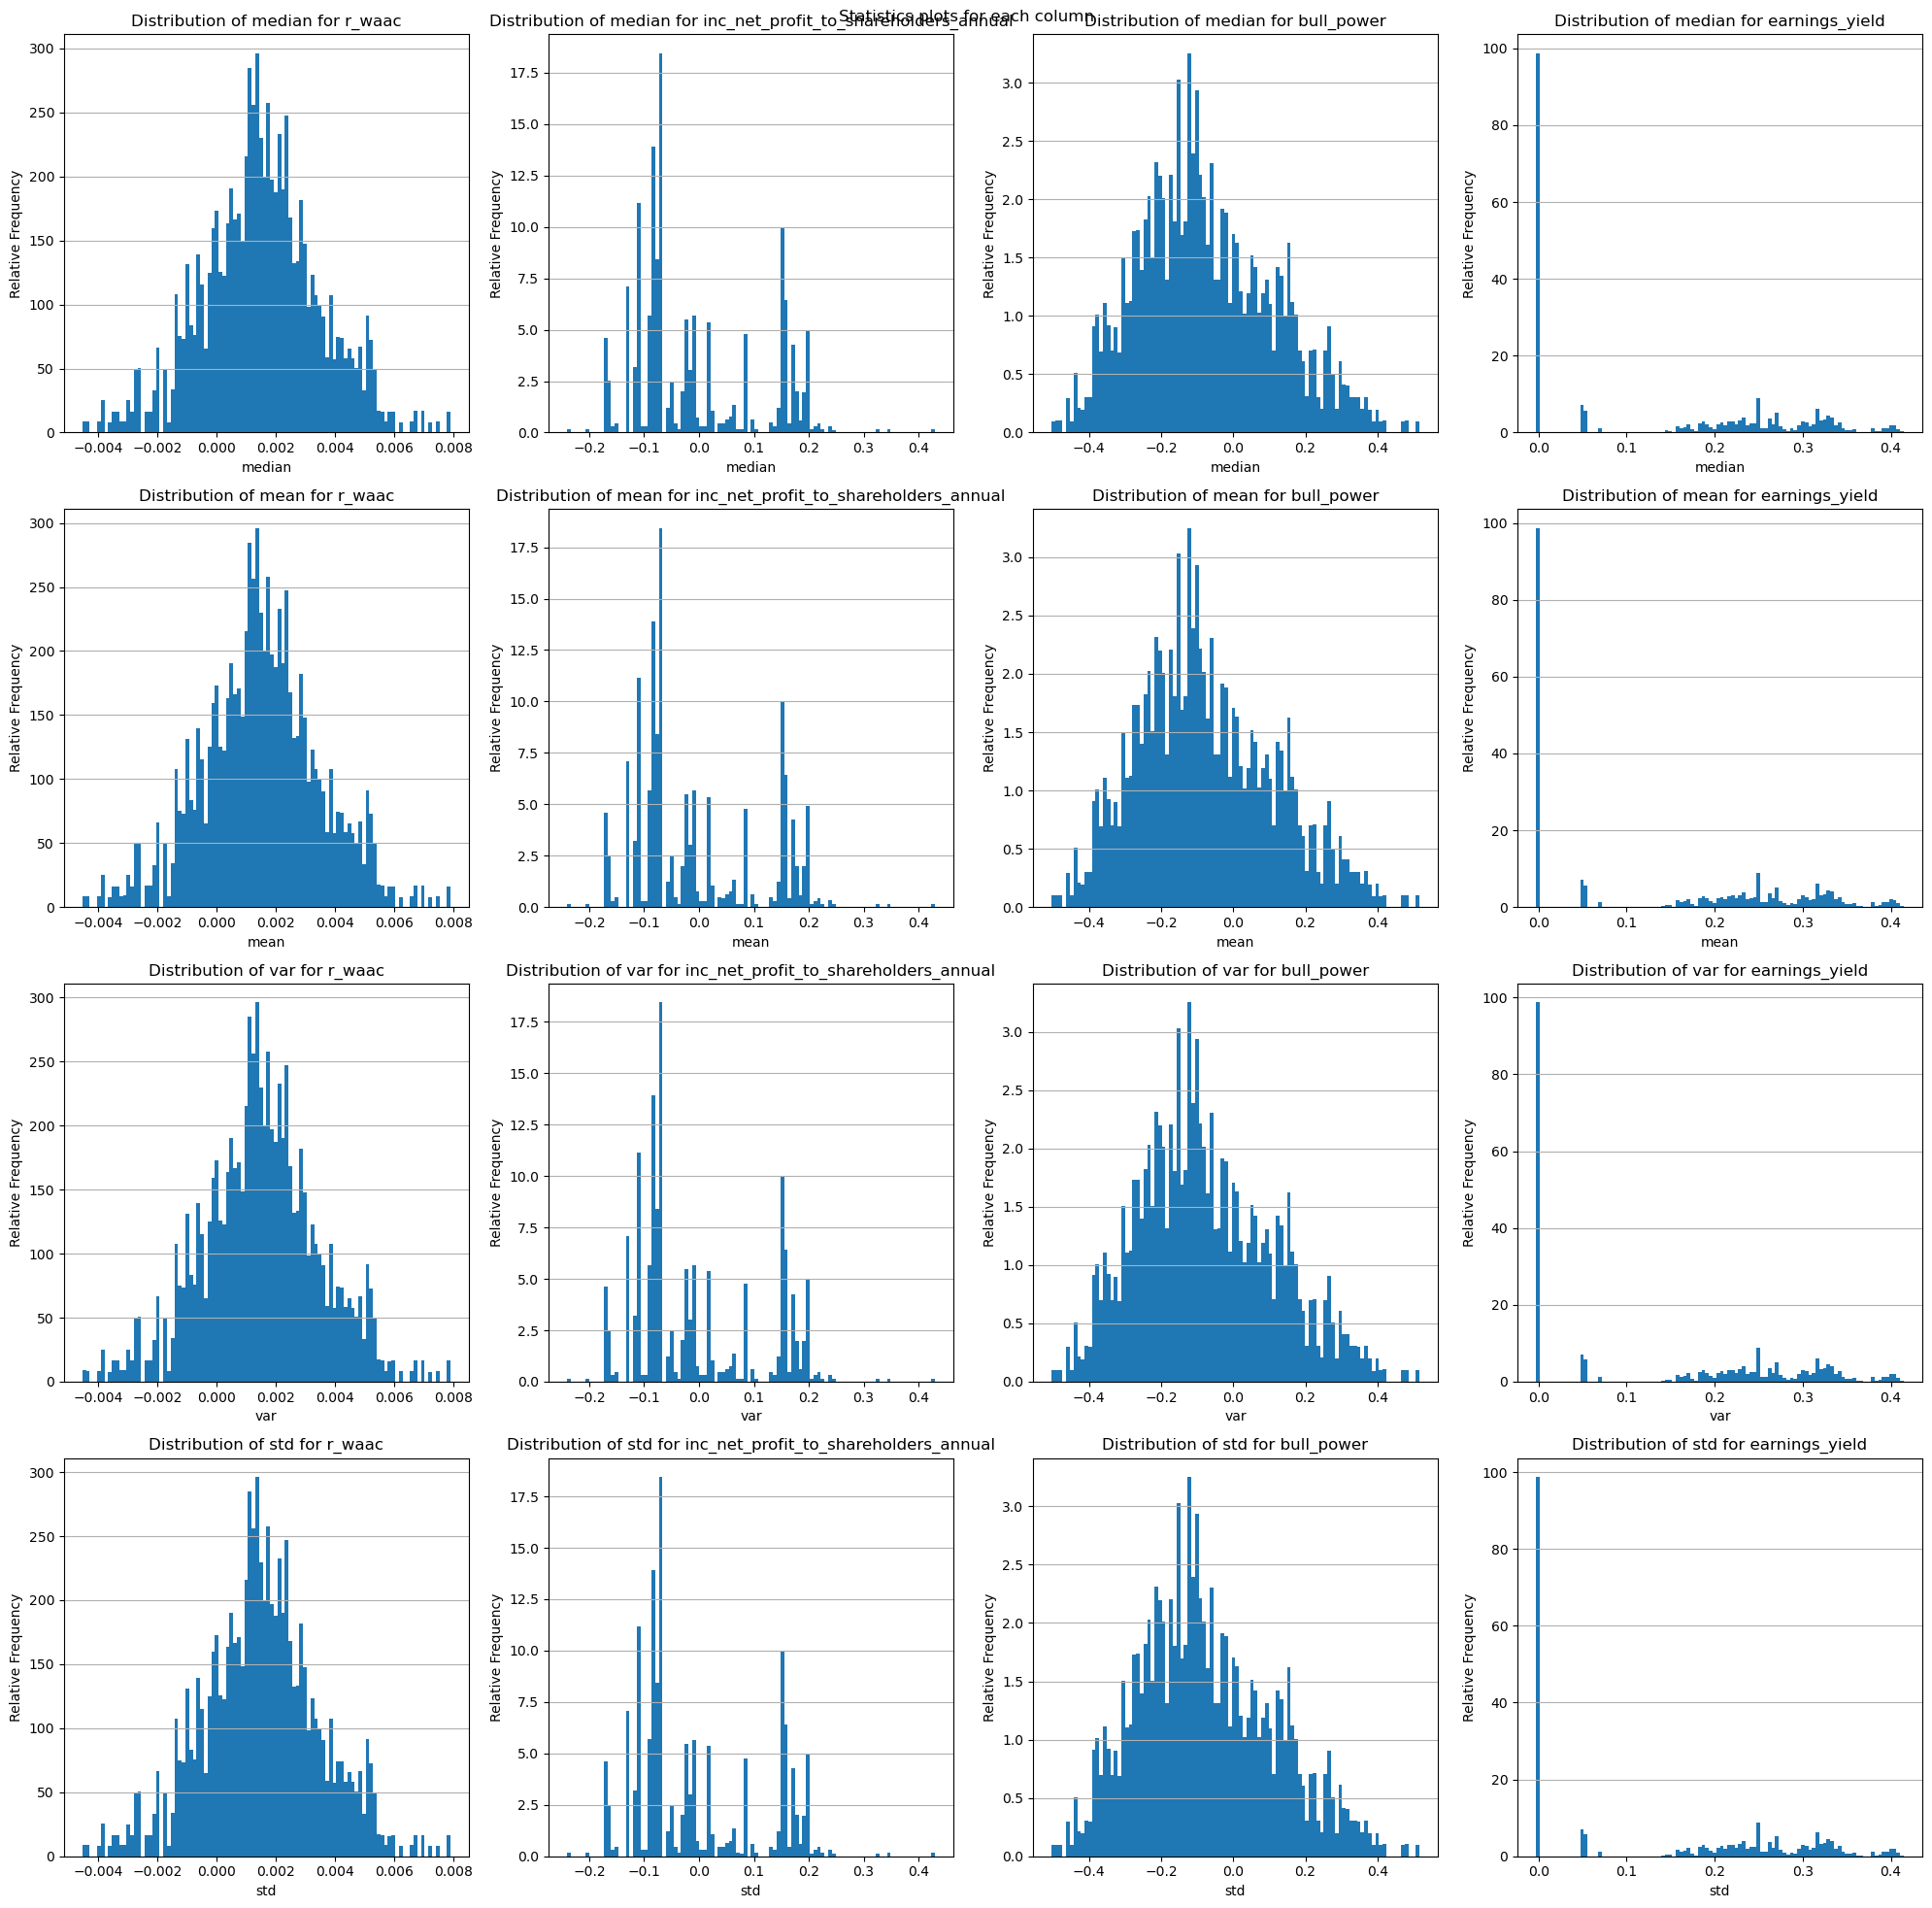

,r_waac,inc_net_profit_to_shareholders_annual,bull_power,earnings_yield
median,0.001486,-0.068568,-0.099313,0.170234
mean,0.001520,-0.008519,-0.076029,0.146555
var,0.000004,0.013007,0.035221,0.019820
std,0.001977,0.114049,0.187672,0.140783


In [17]:
random.seed(mol.random_state)

sampled_columns = random.sample(mol.industry_factors_df.columns.tolist(), k=3)
displayed_df = pd.concat([mol.industry_r_waac_df, mol.industry_factors_df[sampled_columns]], axis=1)

dcf.bootstrapping(
    sample=displayed_df,
    sample_frac=0.9,
    samples_count=1000,
    stats=['median', 'mean', 'var', 'std']
)

As can be seen, r_waac and bull_power is highly normalized while others resemble noise.

---
## 5.4 Heatmap for correlation

<Axes: >

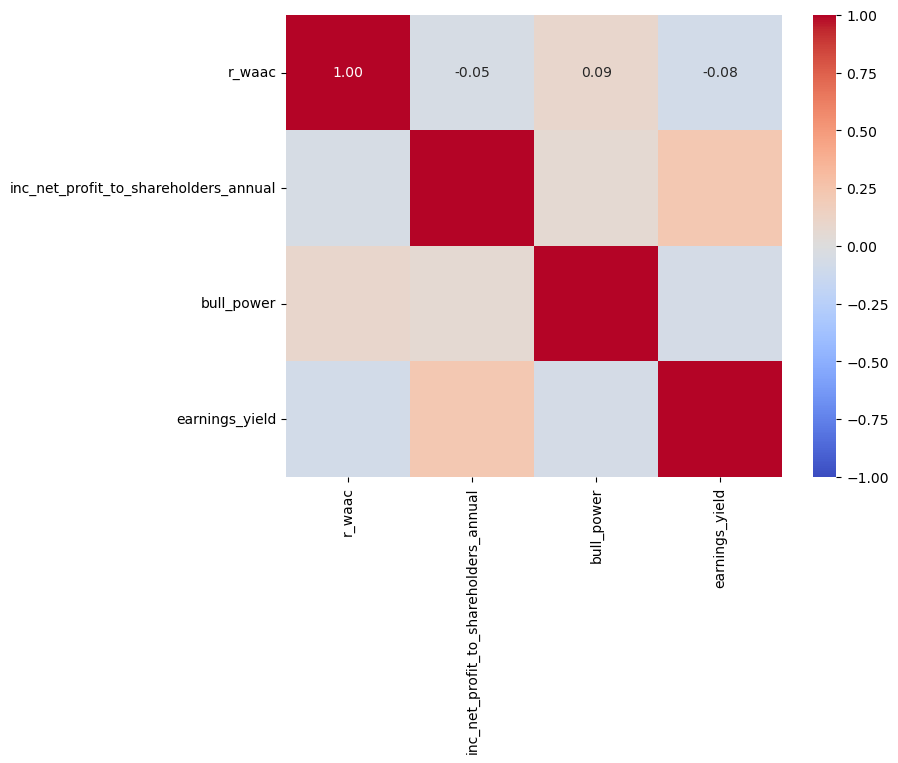

In [18]:
correlation_matrix = displayed_df.corr()

plt.figure(figsize=(8, 6))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f', 
    vmin=-1,
    vmax=1,
    center=0
)

Note that 3 factors are weakly corrrelated:
* `'r_waac'` and `'bull_power'`: Positively correlated.
* `'r_waac'` and `'earnings_yield'`: Negatively correlated.
* `'bull_power'` and `'earnings_yield'`: Negatively correlated. \
while
* `'inc_net_profit_to_shareholders_annual'` is uncorrelatd factor.

---
## 5.3 Time series and Moving average

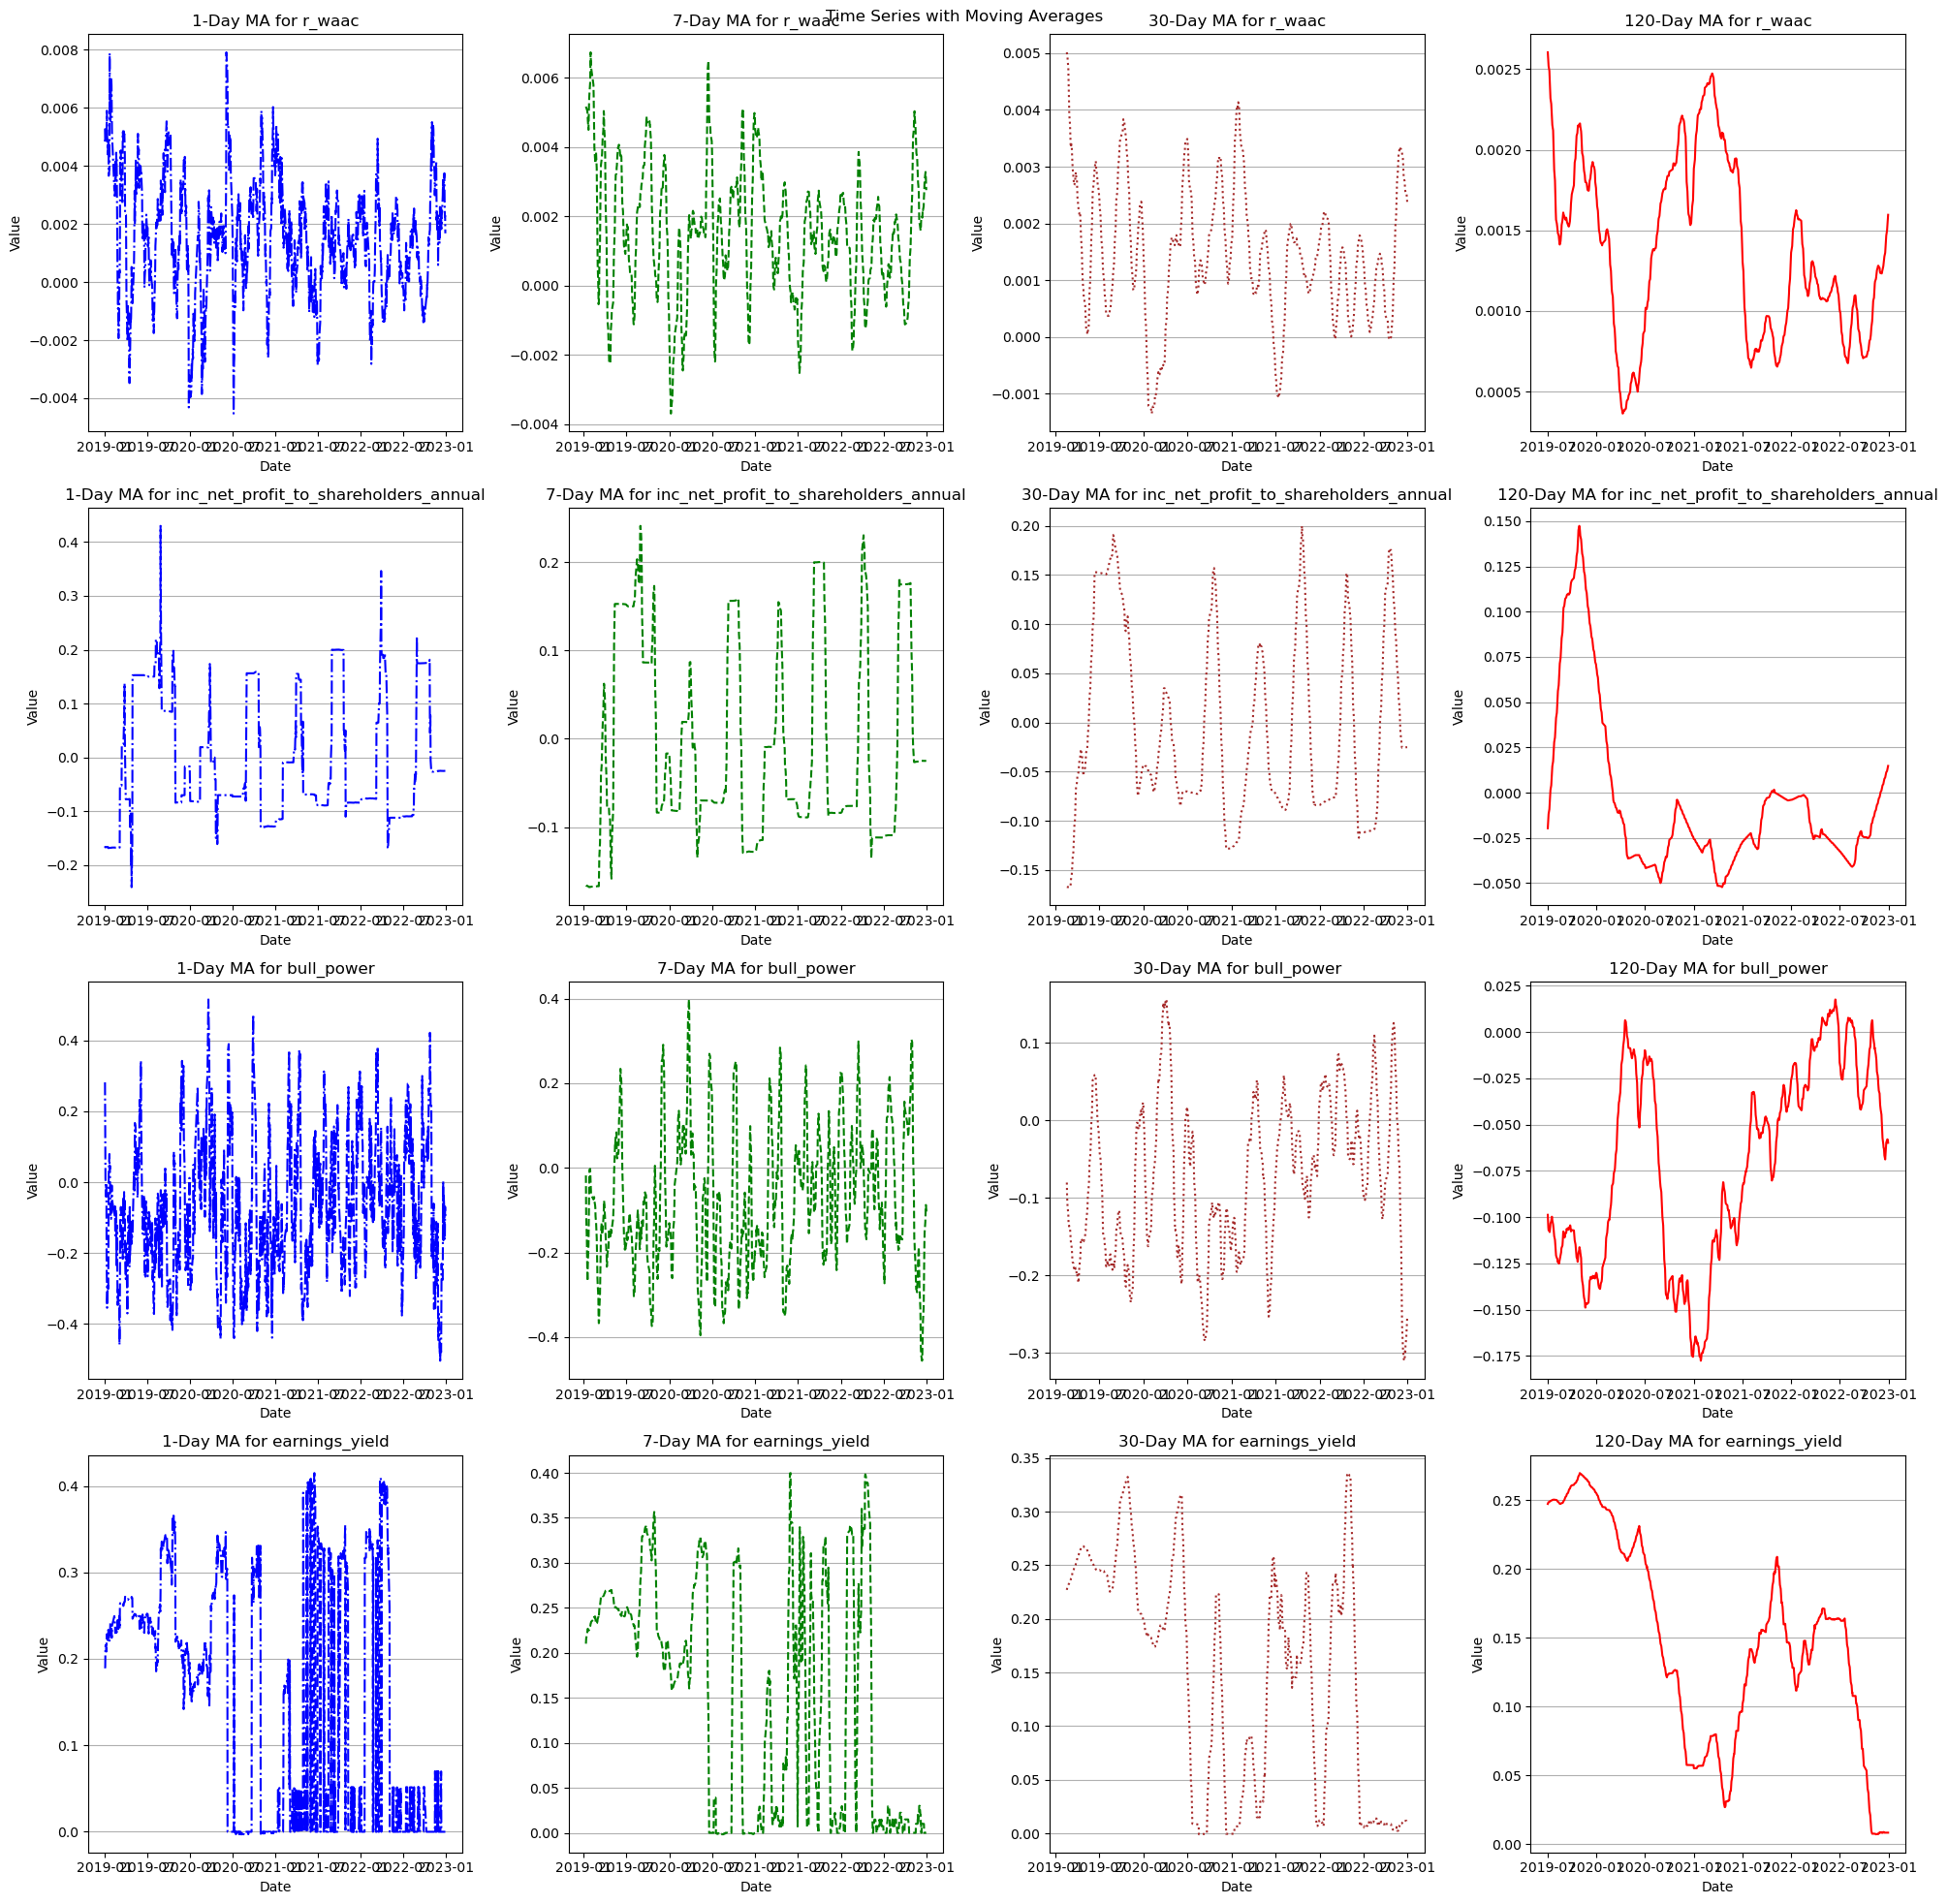

In [19]:
windows = (1, 7, 30, 120)
num_row = len(windows)
num_cols = len(displayed_df.columns)

fig, axes = plt.subplots(
    nrows=num_row,
    ncols=num_cols,
    figsize=(5 * num_cols, 5 * num_row),
    squeeze=False
)

fig.suptitle('Time Series with Moving Averages')
for j, window, color, linestyle in zip(
        range(4),
        (1, 7, 30, 120),
        ('blue', 'green', 'brown', 'red'),
        ('-.', '--', ':', '-')
):
    ma_df = pd.DataFrame()
    for i, col in enumerate(displayed_df.columns):
        ma_df['MA_' + str(window)] = displayed_df[col].rolling(window=window).mean()

        axes[i ,j].plot(mol.index, ma_df['MA_' + str(window)], color=color, linestyle=linestyle)
        axes[i, j].set_title(f'{window}-Day MA for {col}')
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Value')
        axes[i, j].grid(axis='y')

    ma_df.index = mol.index

plt.tight_layout()
plt.show()

The observations about 120-Day MA are that:

* `'r_waac'` and `'bull_power'`: Coincided pattern.
* `'r_waac'` and `'earnings_yield'`: Negatively correlated.
* `'bull_power'` and `'earnings_yield'`: Negatively correlated. \
while
* `'inc_net_profit_to_shareholders_annual'` has unique pattern.

---
## 5.3 Time series and Moving average